# Образец результата

прогноз на апрель - август 2023, сделанный на данных до марта включительно

In [1]:
# Относительные ссылки, включая импорты, относительно корневой папки проекта
import os
os.chdir(os.path.dirname(os.getcwd()))

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import warnings


In [145]:
# Факт на задание
fact = pd.read_csv("./DataWagon/data/fact_train_test.csv", sep=";", decimal=",", encoding="windows-1251")
fact["period"] = fact["period"].astype("datetime64[ns]")
start_date_prep =  datetime(2017, 1, 1).strftime("%Y-%d-%m")
fact = fact.loc[fact['period'] >= start_date_prep]

# Пример прогноза - наивный, копия последнего факта
# result = []
# last_known_fact_month = fact["period"].max()
# test_periods = pd.date_range(start=fact["period"].max()+pd.DateOffset(months=1), periods=5, freq='MS')#, inclusive='right'
# for period in test_periods:
#     print(period)
#     month_forecast = fact[fact["period"] == last_known_fact_month].reset_index(drop=True)
#     month_forecast["period"] = period
#     result.append(month_forecast)
# result = pd.concat(result).reset_index(drop=True)
# # result.rename(columns={"real_wagon_count": "forecast_wagon_count", "real_weight": "forecast_weight"}, inplace=True)
# result.to_csv("./DataWagon/data/forecast_example.csv", index=False, sep=";", decimal=",", encoding="windows-1251")


In [146]:
fact

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
2468,2017-01-01,0,0,0,-1,23,11020,37638,672,62.0,5
2469,2017-01-01,0,0,0,-1,4225,11020,37638,672,13.0,2
2470,2017-01-01,0,0,0,-1,4228,11020,37638,672,6.0,0
2471,2017-01-01,0,0,0,-1,4293,11020,37638,672,14.0,0
2472,2017-01-01,0,0,0,-1,3320,11020,37638,672,52.0,0
...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,69.0,1
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,70.0,1
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,70.0,1
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,207.0,3


In [ ]:
import mitosheet
mitosheet.sheet(fact, analysis_to_replay="id-ltfttkuuht")

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(fact['sender_station_id'], ax=ax, lags=72, method='ywm')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(fact['real_wagon_count'], ax=ax, lags=72)
plt.show()

### LightGBM

In [104]:
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [147]:
df = fact.copy()
df_agg = df.groupby([
        df.period.dt.date, 
        "rps",
        "client_sap_id",
        "sender_station_id",
        "recipient_station_id",
        "real_wagon_count",
]).sum().reset_index()
# result_agg.loc[result_agg['period']<= end_validation, 'real_wagon_count'], 
end_train =  datetime(2023, 3, 1).date()#.strftime("%Y-%d-%m")
exclude_col = ['real_wagon_count', 'period']

data_train = df_agg.loc[df_agg['period'] <= end_train]
data_test = df_agg.loc[df_agg['period'] > end_train]

X_train = data_train.drop(exclude_col, axis=1)
X_test = data_test.drop(exclude_col, axis=1)
y_train = data_train['real_wagon_count']
y_test = data_test['real_wagon_count']

model = LGBMRegressor(random_state=42) #LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
# predictions = model.predict(X_test)
# mae = np.round(mean_absolute_error(y_test, predictions), 3)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3092318, number of used features: 9
[LightGBM] [Info] Start training from score 22.690465


LGBMRegressor(random_state=42)

In [148]:
result = []
last_known_fact_month = fact["period"].max()#-pd.DateOffset(months=5)
test_periods = pd.date_range(start=fact["period"].max()+pd.DateOffset(months=1), periods=5, freq='MS')#, inclusive='right'

new_12_months = fact[fact["period"]>=last_known_fact_month-pd.DateOffset(months=6)].reset_index(drop=True)
for i, period in enumerate(test_periods):
    print(period)
    # last_known_fact_month += pd.DateOffset(months=1)
    # print(last_known_fact_month)
    # month_forecast = fact[fact["period"] == last_known_fact_month].reset_index(drop=True) #new_12_months.copy()
    month_forecast = new_12_months.copy()
    month_forecast["period"] = period
    result.append(month_forecast)
result = pd.concat(result).reset_index(drop=True)

pred_row = result.drop(exclude_col, axis=1)
predictions = model.predict(pred_row)

result['real_wagon_count'] = predictions.round()
print(len(result))
# result = result[result['real_wagon_count']> 0]
# result.loc[result['client_sap_id']==-1, ['client_sap_id']] = 0
print(len(result))

2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
1552630
1552630


In [142]:
result = result.reset_index(drop=True)
result.rename(columns={"real_wagon_count": "forecast_wagon_count", "real_weight": "forecast_weight"}, inplace=True)
result.to_csv("./DataWagon/data/forecast_example4.csv", index=False, sep=";", decimal=",", encoding="windows-1251")


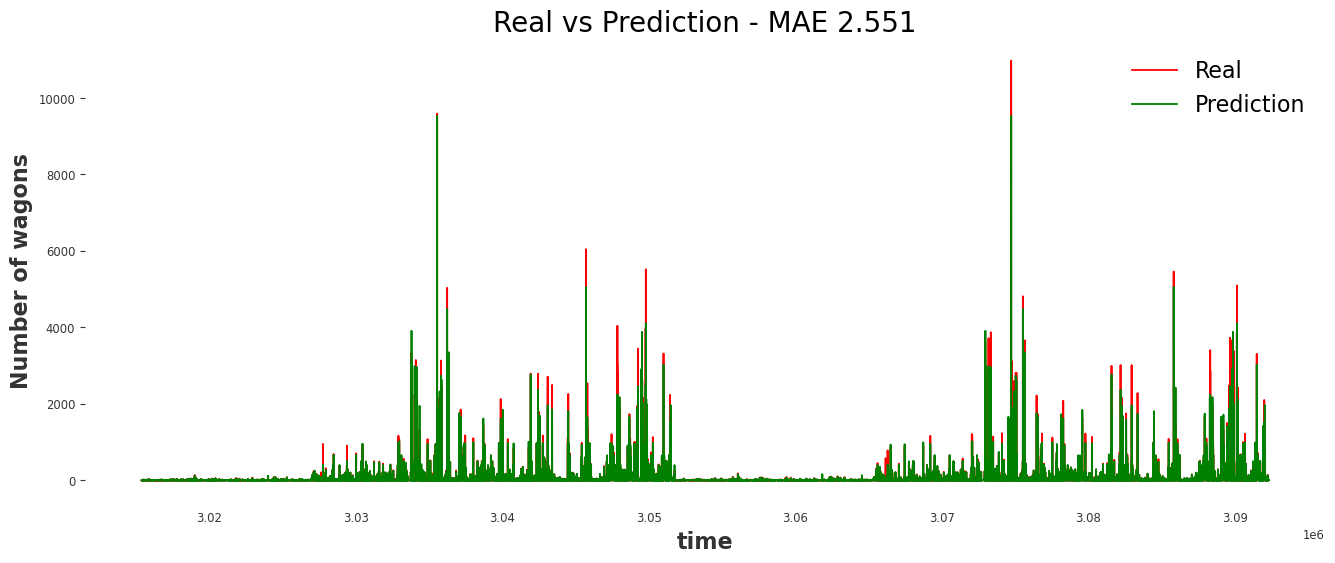

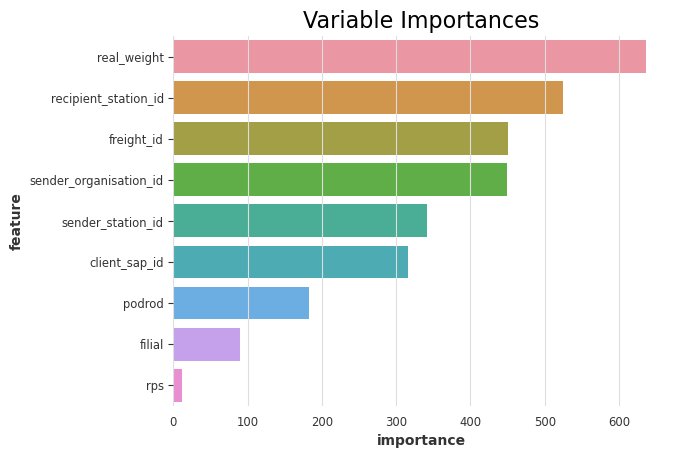

In [106]:
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(y_test, color='red')
plt.plot(pd.Series(predictions, index=y_test.index), color='green')
plt.xlabel('time', fontsize=16)
plt.ylabel('Number of wagons', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()

#create a dataframe with the variable importances of the model
df_importances = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False) 

#plot variable importances of the model
plt.title('Variable Importances', fontsize=16)
sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
plt.show()


## Sum by month

In [120]:
# result_agg = result.groupby([
#     result.period.dt.date, 'podrod', 'sender_station_id', 'recipient_station_id', 'client_sap_id', 'freight_id', 'real_wagon_count'
# ]).sum().reset_index() #agg({'real_wagon_count': 'sum'}) result.period.dt.month, 


In [19]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skforecast.model_selection import backtesting_forecaster
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123), #CatBoostRegressor(random_state=123, silent=True, allow_writing_files=False),
                 lags = 1
             )

In [20]:
end_train =  datetime(2023, 1, 1).date() #.strftime("%Y-%d-%m")
exclude_col = ['real_wagon_count', 'period']
data1 = fact.copy()
result_agg = data1.groupby([
        data1.period.dt.date, 
        "rps",
        "client_sap_id",
        "sender_station_id",
        "recipient_station_id",
        "real_wagon_count",
]).sum().reset_index() #agg({'real_wagon_count': 'sum'}) result.period.dt.month, 

data_train = result_agg.loc[result_agg['period'] <= end_train]
data_test = result_agg.loc[result_agg['period'] > end_train]

In [ ]:
warnings.filterwarnings('ignore')

param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = result_agg['real_wagon_count'], # Train and validation data
                   param_grid         = param_grid,
                   # lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

In [33]:
# import plotly.express as px
# fig = px.histogram(fact, x='period', y='real_wagon_count')
# fig.show()


In [12]:
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = result_agg['real_wagon_count'],
                            initial_train_size = len(data_train),
                            fixed_train_size   = False,
                            steps              = 36,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            n_jobs             = 'auto',
                            verbose            = False # Change to True to see detailed information
                      )        

print(f"Backtest error: {metric:.2f}")
predictions.head()


  0%|          | 0/2137 [00:00<?, ?it/s]

Backtest error: 20805.70


,pred
3015394,12.381899
3015395,14.949029
3015396,15.289831
3015397,15.670886
3015398,18.712432


In [17]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['real_wagon_count'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="real_wagon_count",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

## df_agg darts

In [2]:
from darts import TimeSeries
from darts.models import TCNModel, RNNModel, FFT, AutoARIMA, ExponentialSmoothing, Theta
from darts.models import (
    ExponentialSmoothing,
    KalmanForecaster,
    LinearRegressionModel,
    NaiveDrift,
    NaiveEnsembleModel,
    NaiveSeasonal,
    RandomForest,
    RegressionEnsembleModel,
    TCNModel,
)
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score, mae

df = fact.copy()
df_agg = df.groupby([
        df.period.dt.date, 
        "rps",
        "client_sap_id",
        "sender_station_id",
        "recipient_station_id",
        "real_wagon_count",
]).sum().reset_index()
time_series = TimeSeries.from_dataframe(df_agg,value_cols="real_wagon_count", static_covariates=["rps","client_sap_id","sender_station_id","recipient_station_id"])
time_series

C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


NameError: name 'fact' is not defined

In [ ]:
df = fact.copy()
# df_agg = df.groupby([
#         df.period.dt.date, 
#         "rps",
#         "client_sap_id",
#         "sender_station_id",
#         "recipient_station_id",
#         "real_wagon_count",
# ]).sum().reset_index()
time_series = TimeSeries.from_group_dataframe(df,group_cols=["period","rps","client_sap_id","sender_station_id","recipient_station_id"], time_col="period")
time_series

In [ ]:
time_series.plot()

In [ ]:
scaler = Scaler()
time_series = scaler.fit_transform(time_series)
train, val = time_series.split_before(2907028)

In [ ]:
naive_ensemble = NaiveEnsembleModel(
    forecasting_models=[NaiveSeasonal(K=12), NaiveDrift()]
)

backtest = naive_ensemble.historical_forecasts(time_series, start=0.6, forecast_horizon=3)

time_series.plot(label="series")
backtest.plot(label="prediction")
print("NaiveEnsemble (naive) MAPE:", round(mape(backtest, time_series), 5))

1


In [ ]:
1

## Fedot

In [182]:
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.repository.dataset_types import DataTypesEnum

In [183]:
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=10))

dataf = InputData(features =df.drop(['real_wagon_count', 'period', 'real_weight'], axis=1).to_numpy(),
                           target=df['real_wagon_count'].to_numpy(),
                           idx=df.index.to_numpy(),
                           task=task,
                           data_type=DataTypesEnum.ts)

In [185]:
train_data, test_data = train_test_data_setup(dataf, validation_blocks=2)


In [186]:
model = Fedot(problem='ts_forecasting',
              task_params=task.task_params,
              timeout=5,
              n_jobs=-1,
              cv_folds=2)

In [187]:
# run AutoML model design
pipeline = model.fit(train_data)
# plot obtained pipeline
pipeline.show()

# use model to obtain two-step in-sample forecast
forecast = model.predict(test_data, validation_blocks=2)
print(model.get_metrics(metric_names=['rmse', 'mae', 'mape'],
                        target=test_data.target, validation_blocks=2))


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

# Оценка результата

In [9]:
# Относительные ссылки, включая импорты, относительно корневой папки проекта
import os
# os.chdir(os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np


In [70]:
def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    # = Пути к справочникам - откорректировать если в реальной системе будут лежать по другому адресу =
    client_mapping_file = "./DataWagon/data/client_mapping.csv"
    freight_mapping_file = "./DataWagon/data/freight_mapping.csv"
    station_mapping_file = "./DataWagon/data/station_mapping.csv"

    # Клиент - холдинг
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")

    # Груз
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")

    # Станции
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df


def evaluate(fact: pd.DataFrame, forecast: pd.DataFrame, public: bool = True) -> float:
    # = Параметры для расчета метрики =
    accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
    fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"
    if public:
        metric_weight = np.array([0.0, 1.0, 0.0, 0.0, 0.0])
    else:
        metric_weight = np.array([0.1, 0.6, 0.1, 0.1, 0.1])

    # = Собственно расчет метрик =
    # 1. Добавляем сущности верхних уровней гранулярности по справочникам
    fact = add_master_data_mappings(fact)
    forecast = add_master_data_mappings(forecast)

    # 2. Расчет KPI
    compare_data = pd.merge(
        fact.groupby(accuracy_granularity, as_index=False)[fact_value].sum(),
        forecast.groupby(accuracy_granularity, as_index=False)[forecast_value].sum(),
        how="outer",
        on=accuracy_granularity,
    ).fillna(0)
    # Против самых хитрых - нецелочисленный прогноз вагоноотправок не принимаем
    compare_data[fact_value] = np.around(compare_data[fact_value]).astype(int)
    compare_data[forecast_value] = np.around(compare_data[forecast_value]).astype(int)

    # 3. Рассчитаем метрики для каждого месяца в выборке
    compare_data["ABS_ERR"] = abs(
        compare_data[forecast_value] - compare_data[fact_value]
    )
    compare_data["MAX"] = abs(compare_data[[forecast_value, fact_value]].max(axis=1))
    summary = compare_data.groupby("period")[
        [forecast_value, fact_value, "ABS_ERR", "MAX"]
    ].sum()
    summary["Forecast Accuracy"] = 1 - summary["ABS_ERR"] / summary["MAX"]

    # 4. Взвесим метрики отдельных месяцев для получения одной цифры score
    score = (
        summary["Forecast Accuracy"].sort_index(ascending=True) * metric_weight
    ).sum()

    return score


def calc_score_public(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=True)


def calc_score_private(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=False)



In [143]:
# = Примеры файлов для проверки =
validation_file = "./DataWagon/data/forecast_example.csv"
forecast_file = "./DataWagon/data/forecast_example4.csv"

fact = pd.read_csv(validation_file, sep=";", decimal=",", encoding="windows-1251")
print("Валидационный датасет:", fact.shape)
forecast = pd.read_csv(forecast_file, sep=";", decimal=",", encoding="windows-1251")
print("Complete датасет:", forecast.shape)
forecast["period"] = forecast["period"].astype("datetime64[ns]")
fact["period"] = fact["period"].astype("datetime64[ns]")

# Скорим
score_public = calc_score_public(fact, forecast)
score_private = calc_score_private(fact, forecast)
print(f"Public score: {score_public}")
print(f"Private score: {score_private}")


Валидационный датасет: (239605, 11)
Complete датасет: (1552630, 11)
Public score: 0.16606418495356956
Private score: 0.16606418495356956


In [59]:
# Пример прогноза - наивный, копия последнего факта
result = []
last_known_fact_month = fact["period"].max()
test_periods = pd.date_range(end=last_known_fact_month, periods=5, freq='MS')
for period in test_periods:
    print(period)
    month_forecast = fact[fact["period"] == last_known_fact_month].reset_index(drop=True)
    month_forecast["period"] = period
    result.append(month_forecast)
result = pd.concat(result).reset_index(drop=True)
result.rename(columns={"real_wagon_count": "forecast_wagon_count", "real_weight": "forecast_weight"}, inplace=True)

df = fact.copy()
df['cut'] = pd.cut(fact['period'], bins=test_periods)

score_public = calc_score_public(df.dropna().drop(['cut'], axis=1), result)
print(f"Public score: {score_public}")


2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00
Public score: 0.6085383621974237
